# Object detection testing with our custom trained model

**Note: to test the code set the directory location for the inference graph folder**

## Setting the directory and installing the prerequisites

In [1]:
pwd

'C:\\Users\\osman\\Desktop\\Final_Model\\Mobilenet\\models_Tf\\research\\object_detection'

In [2]:
cd  C:/Users/osman/Desktop/Final_Model/Mobilenet/models_Tf/research/

C:\Users\osman\Desktop\Final_Model\Mobilenet\models_Tf\research


In [3]:
! pip install --user Cython
! pip install --user contextlib2
! pip install --user pillow
! pip install --user lxml
! pip install --user jupyter
! pip install --user matplotlib

In [ ]:
! pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"

  Cloning https://github.com/philferriere/cocoapi.git to c:\users\osman\appdata\local\temp\pip-install-jma3q0do\pycocotools
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-win_amd64.whl size=87833 sha256=e5536e72014fe8396aef7a591252ca2bcc2b9da0ef63d856add87af9c1986b51
  Stored in directory: C:\Users\osman\AppData\Local\Temp\pip-ephem-wheel-cache-8c4je2mp\wheels\6b\c6\c5\cb6da4cb793a6cb1ab91f6578d76c42686422127eb4dbcea94
Successfully built pycocotools


  Running command git clone -q https://github.com/philferriere/cocoapi.git 'C:\Users\osman\AppData\Local\Temp\pip-install-jma3q0do\pycocotools'


In [18]:
cd  C:/Users/osman/Desktop/Final_Model/Mobilenet/models_Tf/research/

C:\Users\osman\Desktop\Final_Model\Mobilenet\models_Tf\research


In [30]:
# From within TensorFlow/models/research/
! python setup.py build
! python setup.py install

running build
running build_py
running egg_info
writing object_detection.egg-info\PKG-INFO
writing dependency_links to object_detection.egg-info\dependency_links.txt
writing requirements to object_detection.egg-info\requires.txt
writing top-level names to object_detection.egg-info\top_level.txt
reading manifest file 'object_detection.egg-info\SOURCES.txt'
writing manifest file 'object_detection.egg-info\SOURCES.txt'
copying object_detection\object_detection_tutorial.ipynb -> build\lib\object_detection
running install
running bdist_egg
running egg_info
writing object_detection.egg-info\PKG-INFO
writing dependency_links to object_detection.egg-info\dependency_links.txt
writing requirements to object_detection.egg-info\requires.txt
writing top-level names to object_detection.egg-info\top_level.txt
reading manifest file 'object_detection.egg-info\SOURCES.txt'
writing manifest file 'object_detection.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_l

zip_safe flag not set; analyzing archive contents...
object_detection.core.__pycache__.preprocessor.cpython-37: module MAY be using inspect.stack
object_detection.utils.__pycache__.autoaugment_utils.cpython-37: module MAY be using inspect.stack
error: [WinError 5] Access is denied: 'C:\\ProgramData\\Anaconda3\\Scripts\\f2py-script.py'


## Importing the required Libraries

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

In [ ]:
import tkinter
import matplotlib
matplotlib.use('TkAgg')
import pandas as pd
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
import cv2

## Env setup

In [7]:
%matplotlib notebook

## Object detection imports
Here are the imports from the object detection module.

In [8]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

In [9]:
cd  C:/Users/osman/Desktop/Final_Model/Mobilenet/models_Tf/research/object_detection

C:\Users\osman\Desktop\Final_Model\Mobilenet\models_Tf\research\object_detection


### **For the model trained on the first dataset (600 images)**

In [5]:
MODEL_NAME = 'inference_graph'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/pascal_label_map.pbtxt'

### **For the model trained on the second dataset (1500 images)**

In [20]:
MODEL_NAME = 'inference_graph_extra'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training_extra/pascal_label_map.pbtxt'

### **For model trained on first and second datasets (600 x 1500 images)**

In [10]:
MODEL_NAME = 'inference_graph_fresh'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training_fresh/pascal_label_map.pbtxt'

### **Path for model trained on  second and third datasets (1500 x 2500 images)**

In [ ]:
MODEL_NAME = 'inference_graph_23'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training_23/pascal_label_map.pbtxt'

## Helper code

In [11]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Load a (frozen) Tensorflow model into memory.

In [13]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our model predicts `9`, we know that this corresponds to `bed`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [14]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [15]:
category_index

{1: {'id': 1, 'name': 'oven'},
 2: {'id': 2, 'name': 'refrigerator'},
 3: {'id': 3, 'name': 'sink'},
 4: {'id': 4, 'name': 'range hood'},
 5: {'id': 5, 'name': 'bath tub'},
 6: {'id': 6, 'name': 'mirror'},
 7: {'id': 7, 'name': 'toilet seat'},
 8: {'id': 8, 'name': 'towel'},
 9: {'id': 9, 'name': 'bed'},
 10: {'id': 10, 'name': 'dresser cabinet'},
 11: {'id': 11, 'name': 'night table'},
 12: {'id': 12, 'name': 'table lamp'},
 13: {'id': 13, 'name': 'Bowling ball'},
 14: {'id': 14, 'name': 'bowling pins'},
 15: {'id': 15, 'name': 'Bowling rack'},
 16: {'id': 16, 'name': 'Tv screen'},
 17: {'id': 17, 'name': 'dining table lamp'},
 18: {'id': 18, 'name': 'dining table'},
 19: {'id': 19, 'name': 'vase'},
 20: {'id': 20, 'name': 'chair'},
 21: {'id': 21, 'name': 'computer'},
 22: {'id': 22, 'name': 'Desk'},
 23: {'id': 23, 'name': 'keyboard'},
 24: {'id': 24, 'name': 'Monitor'},
 25: {'id': 25, 'name': 'printer'}}

# Obect Detection

### 1. Testing with a webcam

In [17]:
def run_inference_for_single_image(image, graph):
    if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

    # Run inference
    output_dict = sess.run(tensor_dict,
                            feed_dict={image_tensor: np.expand_dims(image, 0)})

    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict[
        'detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [26]:
import cv2
cap = cv2.VideoCapture(0)
try:
    with detection_graph.as_default():
        with tf.Session() as sess:
                # Get handles to input and output tensors
                ops = tf.get_default_graph().get_operations()
                all_tensor_names = {output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks'
                ]:
                    tensor_name = key + ':0'
                    if tensor_name in all_tensor_names:
                        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)

                while True:
                    ret, image_np = cap.read()
                    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                    image_np_expanded = np.expand_dims(image_np, axis=0)
                    # Actual detection.
                    output_dict = run_inference_for_single_image(image_np, detection_graph)
                    # Visualization of the results of a detection.
                    vis_util.visualize_boxes_and_labels_on_image_array(
                        image_np,
                        output_dict['detection_boxes'],
                        output_dict['detection_classes'],
                        output_dict['detection_scores'],
                        category_index,
                        instance_masks=output_dict.get('detection_masks'),
                        use_normalized_coordinates=True,
                        line_thickness=8)
                    cv2.imshow('object_detection', cv2.resize(image_np, (800, 600)))
                    if cv2.waitKey(25) & 0xFF == ord('q'):
                        cap.release()
                        cv2.destroyAllWindows()
                        break
except Exception as e:
    print(e)
    cap.release()

### 2. Testing with images

In [ ]:
import glob
TEST_IMAGE_PATHS= glob.glob('test_images_3/*.jpg')
IMAGE_SIZE = (12, 8)

In [17]:
TEST_IMAGE_PATHS

['test_image_2\\image 1.jpg',
 'test_image_2\\image 2.jpg',
 'test_image_2\\image 3.jpg',
 'test_image_2\\image 4.jpg']

In [18]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [19]:
%matplotlib notebook

<IPython.core.display.Javascript object>


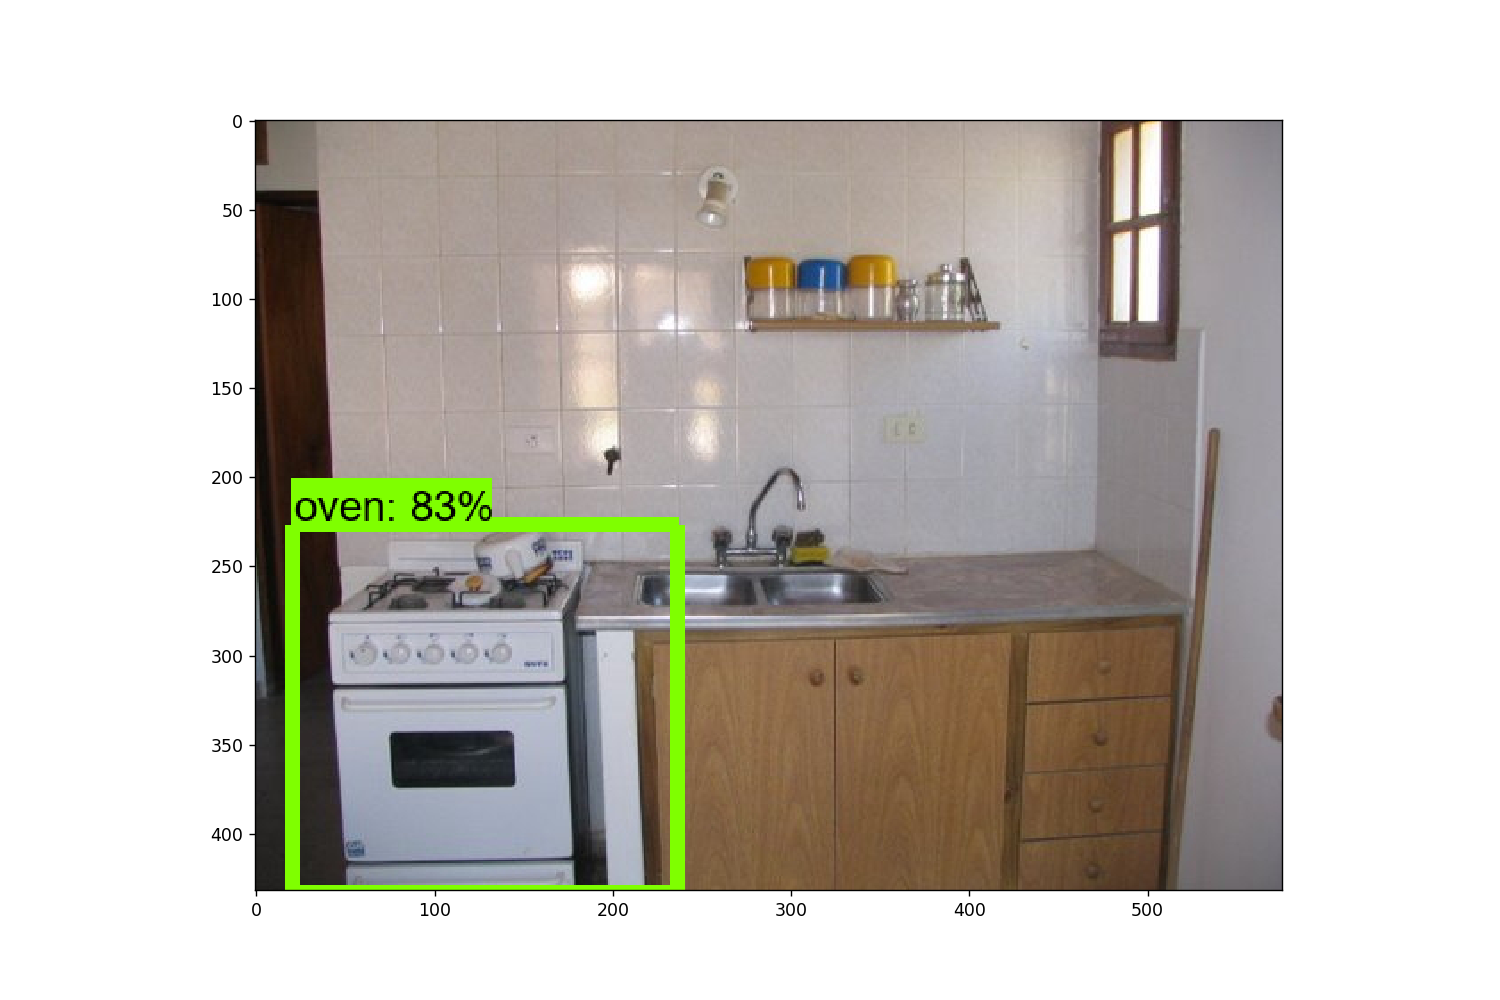

<IPython.core.display.Javascript object>


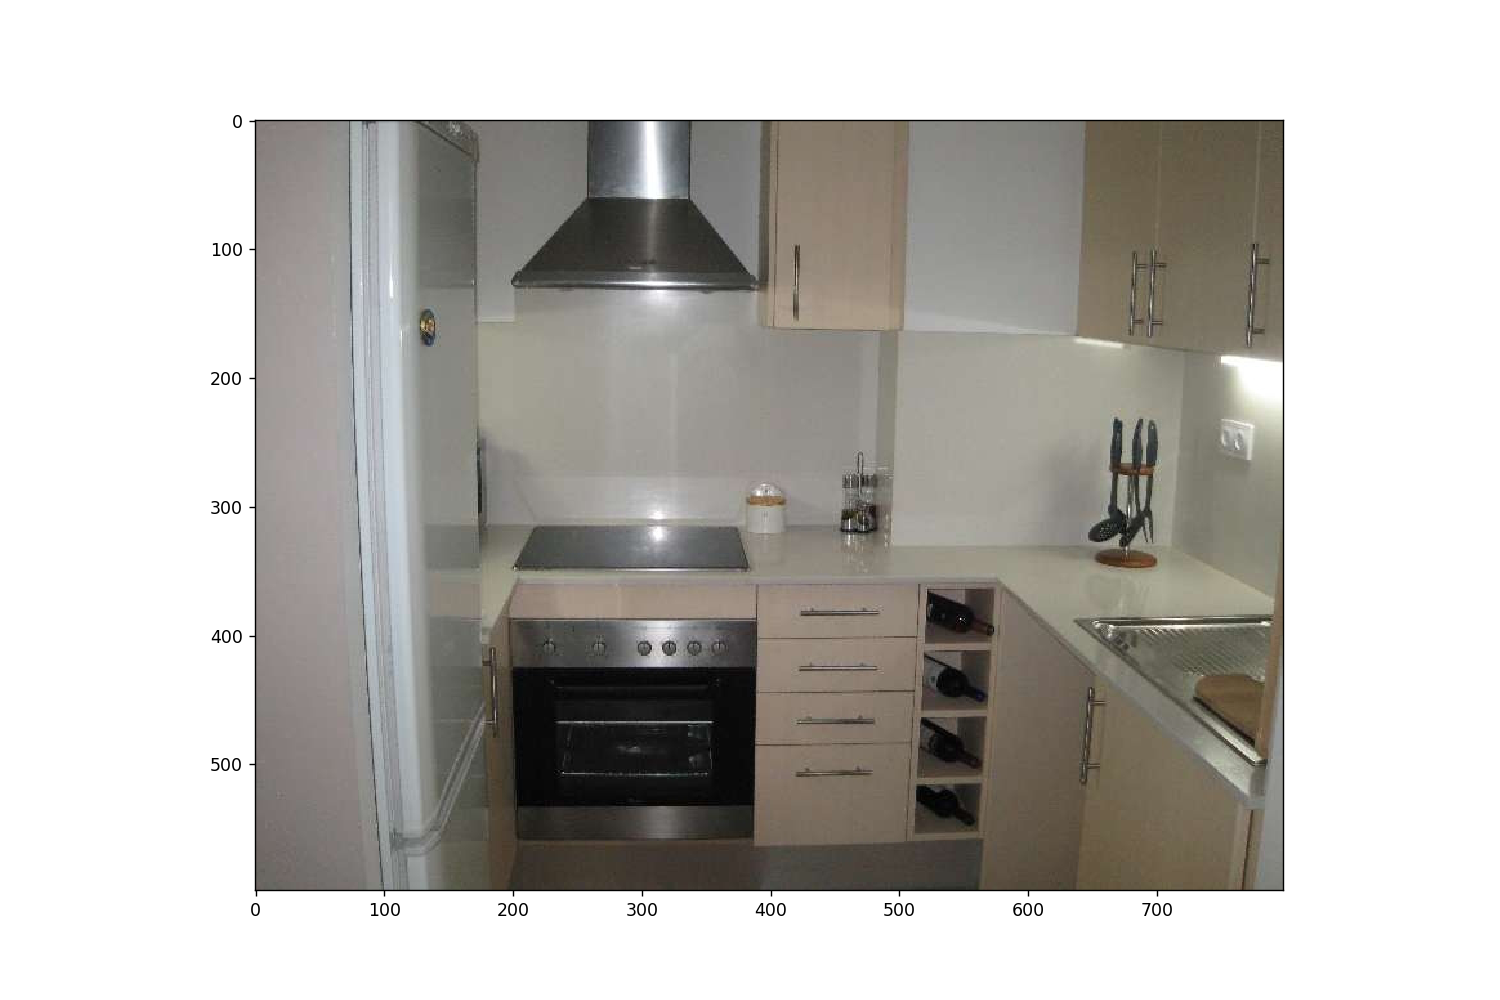

<IPython.core.display.Javascript object>


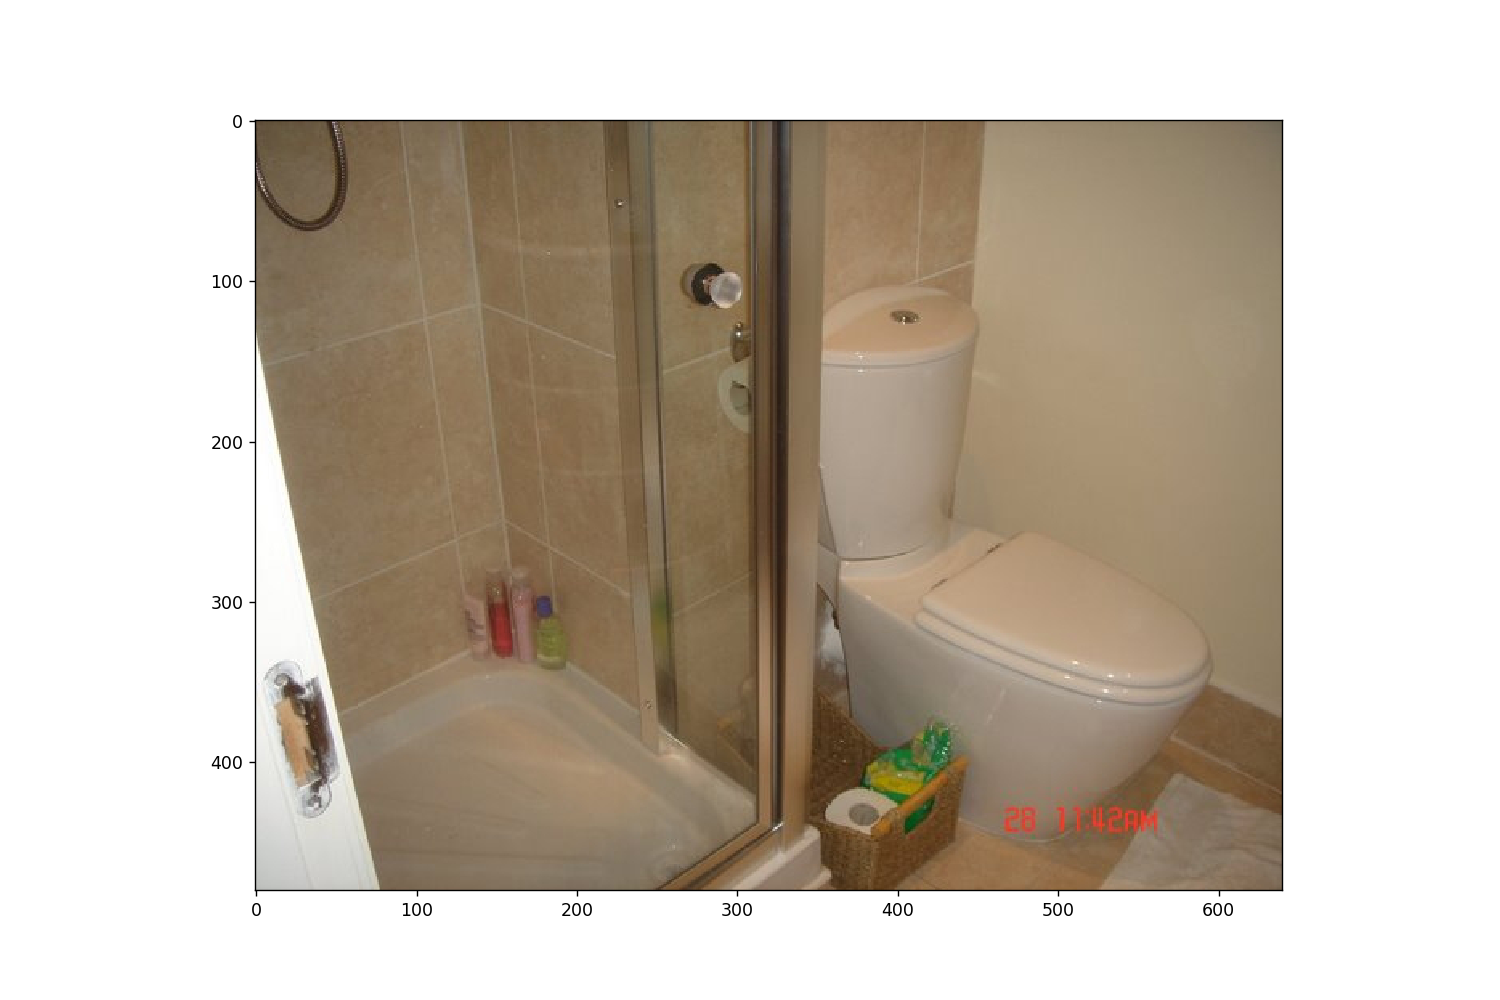

<IPython.core.display.Javascript object>


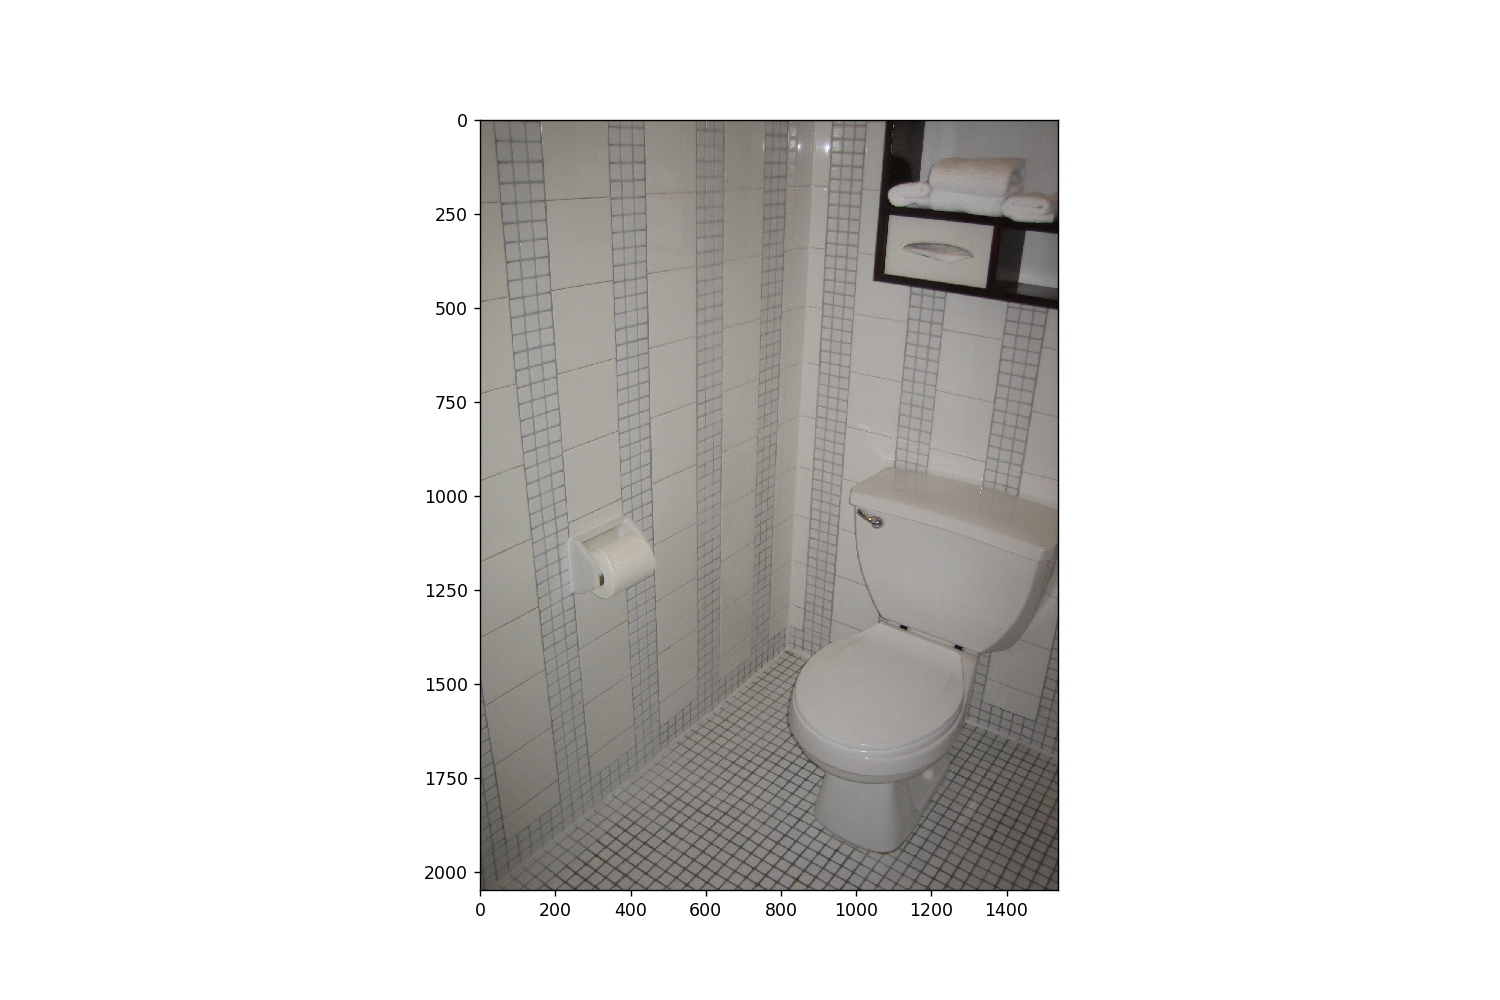

In [20]:
for image_path in TEST_IMAGE_PATHS:
    

    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    #plt.show()  